In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from models import VCN32, VCN16, VCN8

# Transfer Learning
We will run experiments on VCN32, VCN16, and VCN8 to show the effect of transfer learning on training loss convergence. Transfer learning is taking a pretrained model and using it on a similar but different problem. In our case, the encoder backbone of the Fully Convolutional Networks (VCN) uses the convolutional layers of the VGG 11 architecture. 

Transfer learning helps speed up the training time of a model because it has already learned relevant features that may be applied to the current problem we're solving. If you know how to draw a cat, chances are you won't have difficulty learning how to draw a dog (hence the learnings from drawing a cat is "transferable"). To see the effects of transfer learning on training speed, we will train each FCN for 50 epochs on 3 configurations: 

1. <b>Encoder backbone without pretrained VGG 11</b>
2. <b>Encoder backbone = pretrained VGG 11</b>
3. <b>Encoder backbone = pretrained VGG 11 with weights frozen</b>

We will produce training loss curves and compare the results. # Then we will compare the segmentation masks predicted by each model and evaluate performance by pixel accuracy, mean accuracy, mean IU, and frequency weighted IU.

# Device

In [3]:
device = torch.device("mps")
device

device(type='mps')

## VCN Models

In [4]:
vcn32s = [("not pretrained", VCN32(pretrained=False)), 
          ("pretrained", VCN32(pretrained=True)), 
          ("pretrained [frozen]", VCN32(pretrained=True, freeze_pretrained=True))]

vcn16s = [("not pretrained", VCN16(pretrained=False)), 
          ("pretrained", VCN16(pretrained=True).to(device)), 
          ("pretrained [frozen]", VCN16(pretrained=True, freeze_pretrained=True))]

vcn8s = [("not pretrained", VCN8(pretrained=False).to(device)), 
          ("pretrained", VCN8(pretrained=True).to(device)), 
          ("pretrained [frozen]", VCN8(pretrained=True, freeze_pretrained=True))]

models_list = [("FCN32", vcn32s), ("FCN16", vcn16s), ("FCN8", vcn8s)]

# Dataset

In [5]:
from dataset import SegmentationDataset
from torchvision.transforms import ToTensor, Normalize, Compose, Resize

transforms = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    Resize((224, 224))
])

target_transforms = Compose([
    Resize((224, 224))
])

dataset = SegmentationDataset(root="data/stage1_train", transform=transforms, target_transform=target_transforms)

# Training
We are going to overfit each model on 1 point and compare training loss across each model and configuration.

In [6]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
EPOCHS = 100

data = dataset[46]
X = data[0]
Y = data[1][0]

/Users/ericchen/miniconda3/envs/ai/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


''

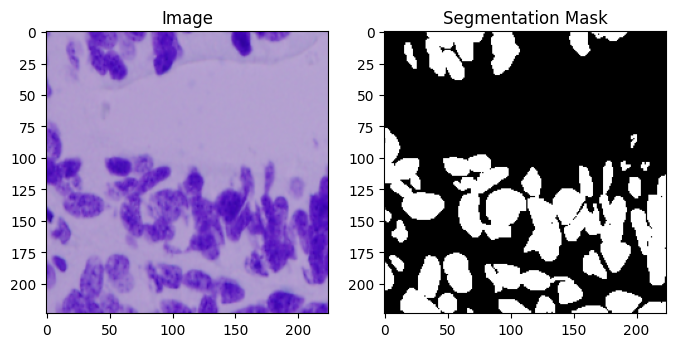

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

inv_normalize = Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
img = inv_normalize(X).permute(1, 2, 0)
mask = Y

ax1.set_title("Image")
ax1.imshow(img)

ax2.set_title("Segmentation Mask")
ax2.imshow(mask, cmap="gray")
;

In [9]:
def train(model, X, Y, criterion, optimizer, epochs, device):
    """
    Train on one data point, X - (C, H, W)
    """
    
    # clear up GPU space
    torch.mps.empty_cache()
    
    losses = []
    pbar = tqdm(range(epochs))
    
    X = X.unsqueeze(0).to(device)
    Y = Y.unsqueeze(0).to(device)
    model = model.to(device)
    
    # set mode to train
    model.train()
    
    for epoch in pbar:
        pred = model(X)
        loss = criterion(pred, Y)
        
        losses.append(loss.item())
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # update progress bar
        pbar.set_description(f"[Epoch {epoch+1}/{epochs}]")
        pbar.set_postfix(loss=loss.item())
        
        
    
    return model, losses

  0%|                                                                                 | 0/100 [00:00<?, ?it/s]/Users/ericchen/miniconda3/envs/ai/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():
[Epoch 100/100]: 100%|██████████████████████████████████████████| 100/100 [00:25<00:00,  3.94it/s, loss=0.305]


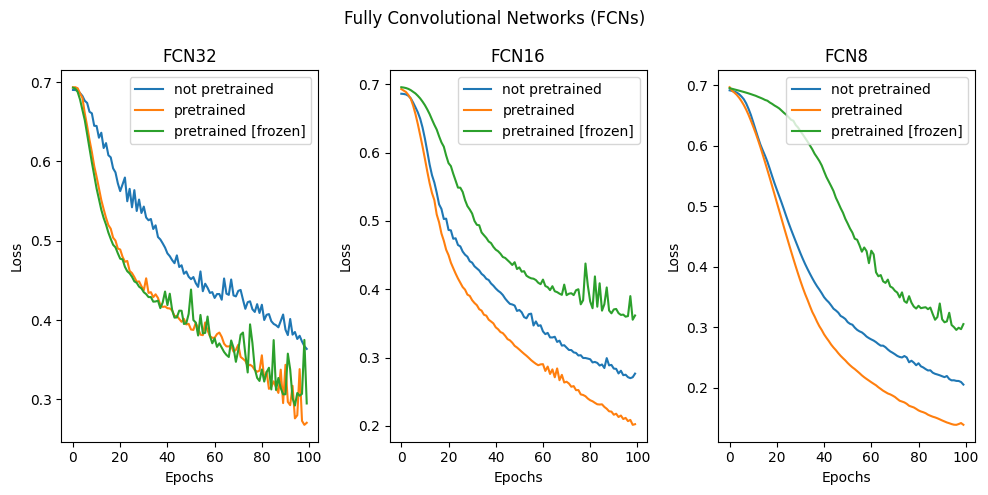

In [10]:
# train each model
num_models = len(models_list)
fig, axes = plt.subplots(1, num_models, figsize=(10, 5))

# cross entropy loss
criterion = torch.nn.CrossEntropyLoss()

for i, (model_name, models) in enumerate(models_list):
    ax = axes[i]
    ax.set_title(model_name)
    for label, model in models:
        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
        trained, losses = train(model, X, Y, criterion=criterion, 
                                    optimizer=optimizer, 
                                    epochs=EPOCHS, 
                                    device=device)
                
        
        ax.plot(range(EPOCHS), losses, label=label)
    
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()

fig.suptitle("Fully Convolutional Networks (FCNs)")
fig.tight_layout()